In [1]:
#@title Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix

In [2]:
#@title Importing Data

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# reading data
train = pd.read_csv('../data/raw/train.csv')
test = pd.read_csv('../data/raw/test.csv')

/var/folders/27/m22rhg4555g1hc5_s5fzq38h0000gn/T/ipykernel_55270/3280349717.py:7: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('../data/raw/train.csv')


In [3]:
#@title Fixing Height

# function to fix heights
def convert_height(height_str):
    if pd.isna(height_str) or height_str in ['-', 'None', 'So', 'Jr', 'Fr', '0']:
        return None
    elif height_str == 'Apr-00':
        return 4*12
    elif height_str == 'May-00':
        return 5*12
    elif height_str == 'Jun-00':
        return 6*12
    elif height_str == 'Jul-00':
        return 7*12
    elif "'" in height_str:
        feet, inches = height_str.split("'")
        return int(feet) * 12 + int(inches)
    elif '-' in height_str:
        try:
            inch, ft = height_str.split("-")
            if ft == 'Jun':
              return int(inch) + 6*12
            elif ft == 'Jul':
              return int(inch) + 7*12
            elif ft == 'May':
              return int(inch) + 5*12
            elif ft == 'Apr':
              return int(inch) + 4*12
        except ValueError:
            return height_str
    else:
        return height_str


train['ht'] = train['ht'].apply(convert_height)
test['ht'] = test['ht'].apply(convert_height)

In [4]:
#@title Undersampling and Dropping Unrequired Features

train2 = train[~train['pick'].isna()]

df = train2.drop(columns = ['type','player_id', 'num'], axis=1)

In [23]:
#@title Preprocessing and Modelling

categorical_cols = ['team', 'conf', 'yr']
numeric_cols = df.drop('drafted', axis=1).select_dtypes(include=['float64', 'int64']).columns.tolist()

# Create transformers for each type of column
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),   # Imputing with mode
    ('onehot', OneHotEncoder(handle_unknown='ignore'))      # One hot encoding
])

numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),              # Imputing with knn
    ('scaler', StandardScaler())                              # Scaling
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# ML model
model = LogisticRegression(solver='liblinear')  #max_iter=200


# overall pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Preprocessing
    ('model', model)
])

# Stratified split
X = df.drop('drafted', axis=1)
y = df['drafted']

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Fiting pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['GP', 'Min_per', 'Ortg',
                                                   'usg', 'eFG', 'TS_per',
                                                   'ORB_per', 'DRB_per',
                                                   'AST_per', 'TO_per', 'FTM',
                                                   'FTA', 'FT_per', 'twoPM',
                                                   'twoPA', 'twoP_per', 'TPM',
                                                   'TPA', 'TP_per', 'blk_per',
                                                   'stl_per', 'ftr', 'ht',
                                                   'porpag', 'adjoe', 'pfr',
                                                   'year', 'Rec_Rank',
                                                   'ast_tov', 'rimmade', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['team', 'conf', 'yr'])])),
                ('model', LogisticRegression(solver='liblinear'))])

In [24]:
#@title Model Evaluation Function

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def model_performance(pipeline, X_test=X_test, y_test=y_test):

  # Make predictions on the test data
  y_pred = pipeline.predict(X_test)
  y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

  # Calculate accuracy, auc, precision, recall
  accuracy = accuracy_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_pred_proba)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)

  print("Accuracy:", accuracy)
  print("AUC:", auc)
  print("Precision:", precision)
  print("Recall:", recall)

  # confusion matrix
  cm = confusion_matrix(y_test, y_pred)

  # Plot the confusion matrix using Seaborn
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix')
  plt.show()

Accuracy: 0.8309352517985612
AUC: 0.903267973856209
Precision: 0.8080808080808081
Recall: 0.7407407407407407


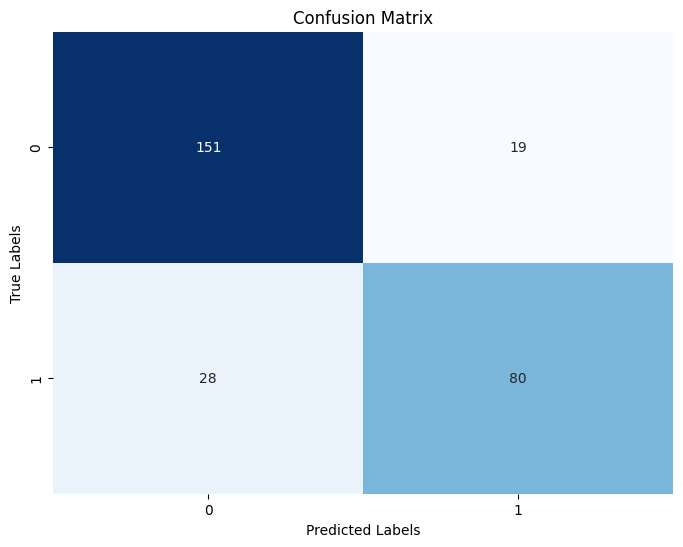

In [25]:
model_performance(pipeline)

In [27]:
#@title Predicting on Kaggle Test Data

df_test = test.copy()
df_test['drafted'] = pipeline.predict_proba(df_test)[:, 1]
df_test['drafted'] = np.where(df_test['pick'].isna(), 0, df_test['drafted'])


In [28]:
df_test[['player_id', 'drafted']].to_csv('pred_0109.csv', index=False)

In [29]:
import joblib

# Save the model to a file
joblib.dump(pipeline, 'final.pkl')

['final.pkl']